Alexandre CARRE*, Marvin LEROUSSEAU, Enzo BATTISTELLA <img align="right" width="400" height="40" src="images/epu_ia_logo.png"> <br> *alexandre.carre@gustaveroussy.fr (Notebook conception) <br> marvin.lerousseau@gustaveroussy.fr (Notebook revision) <br> enzo.battistella@gustaveroussy.fr (Notebook revision)

# TP2: MACHINE LEARNING APPLICATION

In this notebook, you will learn the general fundamentals of machine learning applied to a classification task which is LGG vs GBM. Of course, the aim is not to find the best pipeline with the best algorithm for this task but to understand the principle concept. First, download necessary materials for the afternoon practical sessions.

In [1]:
#!git clone https://github.com/RRouhi/EPU-IA-2021.git
#%cd EPU-IA-2021/
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Master_Class/ML/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Master_Class/ML


### Installation of python dependencies

In [2]:
!pip install sklearn graphviz pydotplus pandas matplotlib numpy


## General Machine Learning Steps

Before we start, let's review the general machine learning steps [1]:

1. Data collection, preprocessing (e.g., integration, cleaning, etc.), and exploration;
   - Split a dataset into the **training** and **testing** datasets
2. Model development:  
    A. Assume a model $\{f\}$ that is a collection of candidate functions $f$’s (representing posteriori knowledge) we want to discover. Let's assume that each $f$ is parametrized by ${w}$  
    B.Define a **cost function** $C({w})$ that measures "how good a particular $f$ can explain the training data." The lower the cost function the better;  
3. **Training:** employ an algorithm that finds the best (or good enough) function $f^{*}$ in the model that minimizes the cost function over the training dataset
4. **Testing**: evaluate the performance of the learned $f^{*}$ using the testing dataset;
5. Apply the model in the real world.

## Load data

In [3]:
import pandas as pd
from IPython.display import display

path_dataset = './data/radiomics_analysis_cleaned.csv'

data = pd.read_csv(path_dataset)
# we will only work with the full area segmentation with all sequences
data = data[data['segmentation']=='full']

data = data.pivot_table(index=['patient', 'label'],
                                columns=['sequence', 'segmentation'],
                                values=data.columns[4:])
data.columns = ['_'.join(col).strip() for col in data.columns.values]
data.reset_index(level=1, inplace=True)

display(data)

# Convert LGG into class 0 and HGG into class 1
data.loc[data['label'] == 'HGG', 'label'] = 1
data.loc[data['label'] == 'LGG', 'label'] = 0

,label,original_firstorder_10Percentile_flair_full,original_firstorder_10Percentile_t1_full,original_firstorder_10Percentile_t1ce_full,original_firstorder_10Percentile_t2_full,original_firstorder_90Percentile_flair_full,original_firstorder_90Percentile_t1_full,original_firstorder_90Percentile_t1ce_full,original_firstorder_90Percentile_t2_full,original_firstorder_Energy_flair_full,original_firstorder_Energy_t1_full,original_firstorder_Energy_t1ce_full,original_firstorder_Energy_t2_full,original_firstorder_Entropy_flair_full,original_firstorder_Entropy_t1_full,original_firstorder_Entropy_t1ce_full,original_firstorder_Entropy_t2_full,original_firstorder_InterquartileRange_flair_full,original_firstorder_InterquartileRange_t1_full,original_firstorder_InterquartileRange_t1ce_full,original_firstorder_InterquartileRange_t2_full,original_firstorder_Kurtosis_flair_full,original_firstorder_Kurtosis_t1_full,original_firstorder_Kurtosis_t1ce_full,original_firstorder_Kurtosis_t2_full,original_firstorder_Maximum_flair_full,original_firstorder_Maximum_t1_full,original_firstorder_Maximum_t1ce_full,original_firstorder_Maximum_t2_full,original_firstorder_Mean_flair_full,original_firstorder_Mean_t1_full,original_firstorder_Mean_t1ce_full,original_firstorder_Mean_t2_full,original_firstorder_MeanAbsoluteDeviation_flair_full,original_firstorder_MeanAbsoluteDeviation_t1_full,original_firstorder_MeanAbsoluteDeviation_t1ce_full,original_firstorder_MeanAbsoluteDeviation_t2_full,original_firstorder_Median_flair_full,original_firstorder_Median_t1_full,original_firstorder_Median_t1ce_full,...,original_shape_Maximum2DDiameterColumn_flair_full,original_shape_Maximum2DDiameterColumn_t1_full,original_shape_Maximum2DDiameterColumn_t1ce_full,original_shape_Maximum2DDiameterColumn_t2_full,original_shape_Maximum2DDiameterRow_flair_full,original_shape_Maximum2DDiameterRow_t1_full,original_shape_Maximum2DDiameterRow_t1ce_full,original_shape_Maximum2DDiameterRow_t2_full,original_shape_Maximum2DDiameterSlice_flair_full,original_shape_Maximum2DDiameterSlice_t1_full,original_shape_Maximum2DDiameterSlice_t1ce_full,original_shape_Maximum2DDiameterSlice_t2_full,original_shape_Maximum3DDiameter_flair_full,original_shape_Maximum3DDiameter_t1_full,original_shape_Maximum3DDiameter_t1ce_full,original_shape_Maximum3DDiameter_t2_full,original_shape_MeshVolume_flair_full,original_shape_MeshVolume_t1_full,original_shape_MeshVolume_t1ce_full,original_shape_MeshVolume_t2_full,original_shape_MinorAxisLength_flair_full,original_shape_MinorAxisLength_t1_full,original_shape_MinorAxisLength_t1ce_full,original_shape_MinorAxisLength_t2_full,original_shape_Sphericity_flair_full,original_shape_Sphericity_t1_full,original_shape_Sphericity_t1ce_full,original_shape_Sphericity_t2_full,original_shape_SurfaceArea_flair_full,original_shape_SurfaceArea_t1_full,original_shape_SurfaceArea_t1ce_full,original_shape_SurfaceArea_t2_full,original_shape_SurfaceVolumeRatio_flair_full,original_shape_SurfaceVolumeRatio_t1_full,original_shape_SurfaceVolumeRatio_t1ce_full,original_shape_SurfaceVolumeRatio_t2_full,original_shape_VoxelVolume_flair_full,original_shape_VoxelVolume_t1_full,original_shape_VoxelVolume_t1ce_full,original_shape_VoxelVolume_t2_full
patient,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0003,HGG,144.118668,-37.915257,3.103941,46.780552,373.385712,95.536186,288.818451,216.258804,2.470281e+10,9.386010e+09,1.464221e+10,1.491739e+10,4.211199,3.586215,4.241624,3.779976,116.424683,71.174101,101.978096,89.773132,9.437376,11.850495,4.528018,10.823671,1057.604614,628.353394,693.214355,780.906616,248.501100,36.910727,115.976699,126.598371,78.671283,48.827477,82.359673,59.059723,226.511520,30.293257,89.257851,...,76.537572,76.537572,76.537572,76.537572,116.709040,116.709040,116.709040,116.709040,104.235311,104.235311,104.235311,104.235311,120.718681,120.718681,120.718681,120.718681,78659.125000,78659.125000,78659.125000,78659.125000,52.041219,52.041219,52.0412

## Splitting datas

Let’s now use <code>train_test_split</code> from the function from scikit-learn to divide features data (x_data) and target data (y_data) even further into train and test. Here we will have 30% of the data for the test set. It is also a good practice to define a random state for reproducible results.

In [4]:
x_data, y_data = data.drop(columns='label'), data['label'].astype(int).to_numpy()

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data ,test_size = 0.3, random_state=123, stratify=y_data)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (170, 400)
x_test shape:  (73, 400)
y_train shape:  (170,)
y_test shape:  (73,)


Now we have our training set wich is a set for training (and validation). The test set is considered like an unseen set and **will be never seen until the model performance evaluation** – this has to be data that your model hasn’t seen before.

But the strategy for evaluate a model depends on your goal and approach. [2]

 - **Scenario 1: Just train a simple model**  
Split the dataset into a separate training and test set. Train the model on the former, evaluate the model on the latter (by “evaluate” I mean calculating performance metrics such as the error, precision, recall, ROC auc, etc.)
 - **Scenario 2: Train a model and tune (optimize) its hyperparameters.**  
Split the dataset into a separate test and training set. Use techniques such as k-fold cross-validation on the training set to find the “optimal” set of hyperparameters for your model. If you are done with hyperparameter tuning, use the independent test set to get an unbiased estimate of its performance. 
 - **Scenario 3: Build differents models and compare algorithms (e.g., SVM vs. logistic regression vs. Random Forests, etc.).**  
Here, we’d want to use nested cross-validation. In nested cross-validation, we have an outer k-fold cross-validation loop to split the data into training and test folds, and an inner loop is used to select the model via k-fold cross-validation on the training fold. After model selection, the test fold is then used to evaluate the model performance. After we have identified our “favorite” algorithm, we can follow-up with a “regular” k-fold cross-validation approach (on the complete training set) to find its “optimal” hyperparameters and evaluate it on the independent test set. 

<a href="https://sebastianraschka.com/faq/docs/evaluate-a-model.html">
  <img src="images/evaluate_overview.png?raw=1" alt="evaluate_overview" class="center">
</a>

# 1) Introduction to data preprocessing

Data pre-processing is an integral step in machine learning because the quality of the data and the useful information that can be derived from it directly affects the ability of our model to learn, so it is extremely important that we pre-process our data before introducing it into our model.

### Handling Null Values

In any real world dataset there are always few null values. Very few models can handle these NULL or NaN values on its own so we need to intervene. In python NULL is represented with NaN. First of all, we need to check whether we have null values in our dataset or not. We can do that using the isnull() method.

In [6]:
data.isnull().sum() # add .any() if you want to know about if there is any NaN in the sum (returns bool)
# Returns the column names along with the number of NaN values in that particular column (we can specify the axis=1, if we want rows)

label                                          0
original_firstorder_10Percentile_flair_full    0
original_firstorder_10Percentile_t1_full       0
original_firstorder_10Percentile_t1ce_full     0
original_firstorder_10Percentile_t2_full       0
                                              ..
original_shape_SurfaceVolumeRatio_t2_full      0
original_shape_VoxelVolume_flair_full          0
original_shape_VoxelVolume_t1_full             0
original_shape_VoxelVolume_t1ce_full           0
original_shape_VoxelVolume_t2_full             0
Length: 401, dtype: int64

We don't have any NaN for our datas. But there is some strategy to handle the missing datas

#### 1. The easiest way to solve the problem of NaN is by dropping the rows or columns that contain null values.

In [7]:
data.dropna(); # (axis=0 for columns or 1 for rows), you have various parameters for dropna(), like 'how', 'tresh',
# take a look at https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

#### 2. Imputation

Imputation is simply the process of substituting the missing values of our dataset. So we can change replace the values by the mean, max, 0, custom function ... Train another algorithm to predict the missing value from the rest of the data

In [8]:
data.fillna(0); # will replace NaN values by a 0, take a look at https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html

### Standardization/Normalization

Different radiomics features have different units and range. Some features were designed to fall between 0 and 1, while others have a very large range. In some machine learning algorithms, the objective functions will not work properly without normalization. For example, many classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a wide range of values, the distance will be governed by that particular characteristic. Therefore, the range of all characteristics should be normalized so that each characteristic contributes approximately proportionally to the final distance. We will present the two most common techniques which are used.

#### 1. Min-Max scaling

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

$$ X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}} $$

Scikit-learn directly implements this for us:

In [9]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_standardize = scaler.transform(x_train)
# We apply the same transform on the test
x_test_standardize = scaler.transform(x_test)

#### 2. Z-Score normalization

It standardize features by removing the mean and scaling to unit variance. By anothers words, we transform our values such that the mean of the values is 0 and the standard deviation is 1.

$$ Z = \frac{x_i - \mu}{\sigma} $$  
with mean: $$ \mu = \frac{1}{N} \sum_{i=1}^N (x_i) $$ 
and standard deviation: $$ \sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2} $$ 

**Exercice:** 
Complete the following scripts to:

- do the Z-Score normalization on the <code>x_train</code> and apply it on the  <code>x_test</code> without using the scikit-learn function.

In [10]:
#@title Exercise 3 {display-mode: "form"}
# %load solutions_exercices/z_score.py

# Two possible function for z_score

import numpy as np
import operator
import pandas as pd


def z_score_1(X):
    # zero mean and unit variance
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)
    z = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return z, mean, std_dev

#  or


def z_score_2(X):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    def _mean(data):
        return float(sum(data) / len(data))

    def _variance(data):
        mu = _mean(data)
        return _mean([(x - mu) ** 2 for x in data])

    def _stddev(data):
        return (_variance(data)) ** 0.5

    def _zscore(data):
        num = [x - _mean(data) for x in data]
        return [x / _stddev(data) for x in num]

    mean = [_mean(x) for x in zip(*X)]
    std_dev = [_stddev(x) for x in zip(*X)]
    z = [_zscore(x) for x in zip(*X)]

    return z, mean, std_dev


x_train_standardize, mean, std_dev = '''CompleteHere'''(x_train)
x_test_standardize = (('''CompleteHere''' - mean) / std_dev)


In [ ]:
#@title Solution 3 {display-mode: "form"}
# %load solutions_exercices/z_score.py

# Two possible function for z_score

import numpy as np
import operator
import pandas as pd


def z_score_1(X):
    # zero mean and unit variance
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)
    z = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return z, mean, std_dev

#  or


def z_score_2(X):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    def _mean(data):
        return float(sum(data) / len(data))

    def _variance(data):
        mu = _mean(data)
        return _mean([(x - mu) ** 2 for x in data])

    def _stddev(data):
        return (_variance(data)) ** 0.5

    def _zscore(data):
        num = [x - _mean(data) for x in data]
        return [x / _stddev(data) for x in num]

    mean = [_mean(x) for x in zip(*X)]
    std_dev = [_stddev(x) for x in zip(*X)]
    z = [_zscore(x) for x in zip(*X)]

    return z, mean, std_dev


x_train_standardize, mean, std_dev = z_score_1(x_train) # or use z_score_2
x_test_standardize = ((x_test - mean) / std_dev)
# Yes, on the test set, you need to apply the value find in the train set!



In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_standardize = scaler.transform(x_train)
# We apply the same transform on the test
x_test_standardize = scaler.transform(x_test)

There are many others techniques, you can consult this link which 
 <a href="https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py">compares the effect of different scalers on data with outliers</a> 

# 2) Building models

#### Standard validation (Hold-Out method)

Previously we have separated our train and test set datas. The entire train data has been used so far to derive estimates of means and variances for each feature such as to perform Z-score normalization. We now further split the training set into a smaller training set and a validation set. The training set samples will all be used to optimize the parameters of a model (i.e. iteratively converge to a satisfying model from the input family of functions), and the validation set will be used to select a good set of hyper-parameters such as the family of functions to optimize (here, logestic regression, decision trees, support vector machines).

The previous fonction from scikit-learn `train_test_split` is used on the pair (features, labels) of extracted training samples:

<a href="https://arxiv.org/pdf/1811.12808.pdf">
  <img src="images/holdout_method.png" alt="holdout_method" class="center"  height="500" width="500" >
</a>

In [12]:
train_features, validation_features, train_labels, validation_labels = \
  train_test_split(x_train, y_train ,test_size = 0.3, random_state=123, stratify=y_train)

print('train_features shape: ', train_features.shape)
print('validation_features shape: ', validation_features.shape)
print('train_labels shape: ', train_labels.shape)
print('validation_labels shape: ', validation_labels.shape)

train_features shape:  (119, 400)
validation_features shape:  (51, 400)
train_labels shape:  (119,)
validation_labels shape:  (51,)


#### Examples of model building with scikit-learn

Of the reasons scikit-learn is the leading data science library worldwide is its simplicity of usage and its consistency. By design, the library implements a wide range of machine learning and data processing algorithms, including the most used machine learning families of functions such as logistic regression or boosting algorithms. Here, we will see some examples of machine learning algorithms, including the standard training pipelines using sklearn. 

Let's look at logistic regression. On paper, logistic regression is handled iteratively, by successively performing inference of the current parametrized model on the training set, and computing a parameters update that is a function of the produced probabilities and the ground-truth annotations. The iterative process is conducted using gradient descent or its _faster_ version stochastic gradient descent. While all of the training process of logistic regression can be coded by hand, its implementation in sklearn lie in two lines:

In [13]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression()  # instantiate a logistic regression model with default parameters
print(logistic_regression_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Training is then performed using the `fit` function, which applies gradient descent with input hyper-parameters, and usually stops once a training hyper-parameter is reached, such as minimal training error tolerance or number of iterations:

In [14]:
clf = logistic_regression_model.fit(X=train_features, y=train_labels)

##### Performance assessment

Once the model is trained, i.e. `fit` function is done, it can be used to classify any input sample with the correct shape, or vectors of 140 features in this case. Notably, training and testing accuracies can be obtained with other performance indicators:

In [15]:
accuracy_train = clf.score(X=train_features, y=train_labels)
probs = clf.predict_proba(train_features)
accuracy_validation = clf.score(X=validation_features, y=validation_labels)
print('Training accuracy', accuracy_train, '; Validation accuracy', accuracy_validation)

Training accuracy 0.8739495798319328 ; Validation accuracy 0.8627450980392157


In this case, the dataset contain more positive samples than negative samples, which imply that a model outputting only the positive class would yield an accuracy higher than 50%. In other words, the accuracy may not always be suited to the needs of the task in hand. Other performance metrics, such as the accuracy, are implemented in scikit-learn (https://scikit-learn.org/stable/modules/model_evaluation.html). By design all implemented performance metrics follow the same api, and take two vectors as input, one for the predictions of any model and one for ground-truths. We first need to explicitely compute probabilities of the trained model and then run sklearn metrics functions:


In [22]:
# Use the trained model (clf) to explicitely compute probabilities of all training and validation samples
predicted_training_probabilities = clf.predict_proba(train_features)[:, 1]  # for each sample, two outputs probas summing to 1: one for class 0 (LGG), the other for class 1 (HGG)
predicted_validation_probabilities = clf.predict_proba(validation_features)[:, 1]  # for each sample, two outputs probas summing to 1: one for class 0 (LGG), the other for class 1 (HGG)

# Compute predicted classes from predicted probabilities by thresholded probabilities with 0.5: a probability higher than 0.5 would yield HGG prediction, otherwise LGG prediction
training_predicted_classes = list(map(lambda proba: int(proba > .5), predicted_training_probabilities))
validation_predicted_classes = list(map(lambda proba: int(proba > .5), predicted_validation_probabilities))

from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Metrics function expect first the ground-truth vector, then the predicted probabilities/classes one
training_balanced_accuracy = balanced_accuracy_score(train_labels, training_predicted_classes)
validation_balanced_accuracy = balanced_accuracy_score(validation_labels, validation_predicted_classes)
print('Training balanced accuracy', training_balanced_accuracy, '; Validation balanced accuracy', testing_balanced_accuracy)

training_auc = roc_auc_score(train_labels, predicted_training_probabilities)
validation_auc = roc_auc_score(validation_labels, predicted_testing_probabilities)
print('Training AUC', training_balanced_accuracy, '; Validation AUC', validation_balanced_accuracy)


Training balanced accuracy 0.869639794168096 ; Validation balanced accuracy 0.8517080745341614
Training AUC 0.869639794168096 ; Validation AUC 0.8517080745341614


Although the balanced accuracy alleviate the issue of class imbalance, it is not a rigourous performance assessment of a decision system. Any decision system performance should be assessed using two measures, such as precision and recall. While giant technology companies can make mistakes in online tools such as Facebook suggesting friends tagging on newly uploaded pictures, in medical routine tasks, errors can have significant impact of patient care or material maintenance. For instance, errors that a patient may be suffering from cancer have less impact than false negative that do not detect patients with cancer. The community would expect guarantees that the level of false negative is close to none for most diagnostic tasks, even if the amount of false positive is significant.

**Exercice:** 
Complete the following script to:

- evaluate the logistic regression model trained above, using sklearn documentation (https://scikit-learn.org/stable/modules/model_evaluation.html)
- more specifically, compute the precision (also called positive predictive value) and recall (also called true positive rate or sensitivity) called  of the trained classifier on both training and testing sets. 

In [ ]:
#@title Exercise 4 {display-mode: "form"}
# %load solutions_exercices/metrics.py

from sklearn.metrics import precision_score, recall_score

training_precision = '''CompleteHere'''(train_labels, training_predicted_classes)
training_recall = '''CompleteHere'''('''CompleteHere''', '''CompleteHere''')

testing_precision = '''CompleteHere'''(validation_labels, testing_predicted_classes)
testing_recall = '''CompleteHere'''('''CompleteHere''', '''CompleteHere''')

print('Training precision', '''CompleteHere''', '; training recall', training_recall)
print('Testing precision', testing_precision, '; Testing recall', '''CompleteHere''')


In [47]:
#@title Solution 4 {display-mode: "form"}
# %load solutions_exercices/metrics.py

from sklearn.metrics import precision_score, recall_score

training_precision = precision_score(train_labels, training_predicted_classes)
training_recall = recall_score(train_labels, training_predicted_classes)

validation_precision = precision_score(validation_labels, testing_predicted_classes)
validation_recall = recall_score(validation_labels, validation_predicted_classes)

print('Training precision', training_precision, '; training recall', training_recall)
print('Testing precision', validation_precision, '; Validation recall', validation_recall)

#Note: pays attention that the two metrics functions take predicted classes as input)

Training precision 0.8695652173913043 ; training recall 0.9090909090909091
Testing precision 0.8181818181818182 ; Validation recall 0.9642857142857143


##### Analysing trained models

We pursue the introduction of scikit-learn with some introspection into the trained logistic regression so far. Fundamentally, logistic regression is parametrized by one parameter per input feature plus one parameter, called bias or intercept with 0. Logistic regression applies a scalar product between the _n+1_ dimensional parameters vector and the input vector, which is then forwarded into the logistic function yielding a value between 0 or 1 apparent to a probability. Therefore, the parameters with higher magnitudes have more impact towards the output of the system than the ones close to 0.

The parameters of any classifier in scikit-learn can be obtained with:

In [24]:
# 1 parameter per input feature + one for intercept with 0
logistic_regression_parameters = clf.coef_
logistic_regression_intercept = clf.intercept_

Here, we pair each parameter with its associated feature name, then we sort the parameters by magnitude, and retrieve the top 10 with most important magnitude i.e. most important features:

In [25]:
# Pair each parameter with its associated feature name
logistic_regression_parameters_with_names = list(zip(logistic_regression_parameters[0], x_data.columns.values))
print('Example of paires param/feature name', logistic_regression_parameters_with_names[:3])

# Sort paired data with respect to absolute value of parameters
logistic_regression_parameters_with_names = sorted(logistic_regression_parameters_with_names, key=lambda pair: abs(pair[0]))

print('\nMost important features:')
# Select top 10 max magnitude parameters and print associated feature name
for parameter_value, feature_name in logistic_regression_parameters_with_names[:-10:-1]:
  print('\t\t', feature_name, 'with value:', str(parameter_value))

Example of paires param/feature name [(2.1706564034604285e-18, 'original_firstorder_10Percentile_flair_full'), (8.541333495586896e-18, 'original_firstorder_10Percentile_t1_full'), (8.3944065919723e-18, 'original_firstorder_10Percentile_t1ce_full')]

Most important features:
		 original_firstorder_TotalEnergy_t1ce_full with value: 2.9602737807497005e-10
		 original_firstorder_Energy_t1ce_full with value: 2.9602737807497005e-10
		 original_firstorder_TotalEnergy_t1_full with value: -2.7877006267283027e-10
		 original_firstorder_Energy_t1_full with value: -2.7877006267283027e-10
		 original_firstorder_TotalEnergy_t2_full with value: -4.2831246154644444e-11
		 original_firstorder_Energy_t2_full with value: -4.2831246154644444e-11
		 original_firstorder_TotalEnergy_flair_full with value: 1.4929718162994204e-11
		 original_firstorder_Energy_flair_full with value: 1.4929718162994204e-11
		 original_glcm_ClusterProminence_flair_full with value: 3.4353643508335884e-14


At this point, we have trained a logistic regression model, have looked at some metrics for assessing performance, and looked into the trained parameters to infer the most important features found by the model. Usually, we would want to further boost the performance of our decision system. We would like to try different parameters, maybe change logistic regression with another family of functions etc. However, we already looked into the testing set, which is all of our holdout set. If we would change one hyper-parameter for our approach, we would not be able to get an unbiased estimator of the performance over an holdout set since the testing set is used to benchmark the impact of changing hyper-parameters. To counter this effect of data leaking, we need to extract another set which will act as a proxy testing set, called a validation set, which is extracted by subsampling from our training set so far such as to preserve as much samples as possible in the testing sets. The validation set is used to benchmark fully trained models with different hyper-parameters, such as to enable out-of-training testing of those propositions.

### Improving performance with hyper-parameters optimization
We saw in the previous section how to implement a logistic regression using scikit-learn for the classification of MRI images into LGG or HGG classes. However, there is no guarantee that the family of functions of logistic regression is the best suited for this task with this type of data. There are a plenty set of families of machine learning decision systems behaving and performing differently given experiments contexts. Therefore, we will look at other families of decision systems on top of logistic regression. More specifically, 6 algorithms will be trained on the training set, and we will use the reported generalization performance on the validation set to extract the best performing family of models. We will also look into another hyper-parameter which is the standardization of the data, and assess similarly the validation generalization performance of models trained with standardization with respect to those trained without to determine whether to apply standardization to the input data.

#### Standard validation (Hold-Out method)

We previously see how it works above !

##### Without Standardization


In [26]:
# Import libraries
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

random_state = 1234

# We load 6 different algorithms with associated algorithm name
models = []
models.append(('Logistic Regression', LogisticRegression(random_state=random_state)))
models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
models.append(('K-nearest neighbours', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=random_state)))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Support Vector Classifier', SVC(random_state=random_state)))


# We will perform the same process for each of the 6 algotithms: train on training set (fit) then get score on validation set
results_without_std = []
for model_name, model in models:
    # Train model; N.B.: training features not standardized were train_features
    clf = model.fit(X=train_features, y=train_labels)
    accuracy_train = clf.score(X=train_features, y=train_labels)  # get train performance
    accuracy_val = clf.score(X=validation_features, y=validation_labels) # get validation performance
    results_without_std.append(accuracy_val)
    print("%s: train = %.3f, validation = %.3f" % (model_name, accuracy_train, accuracy_val))

Logistic Regression: train = 0.874, validation = 0.863
Linear Discriminant Analysis: train = 1.000, validation = 0.745
K-nearest neighbours: train = 0.824, validation = 0.804
Decision Tree Classifier: train = 1.000, validation = 0.745
Gaussian Naive Bayes: train = 0.790, validation = 0.745
Support Vector Classifier: train = 0.798, validation = 0.765


At this point the best expected perfoming algorithm is still logistic regression. K-nearest neighbours come second with an error approximately 1/3 higher. We perform the same experiment with standardized data, which can substantially improve the performance of machine learnig algorithms.

##### With Standardization

In [27]:
# Import librairies
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler


def standardize(x_train, x_test, type='zscore'):
    if type == 'zscore':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train_standardize = scaler.transform(x_train)
    # We apply the same transform on the test
    x_test_standardize = scaler.transform(x_test)
    return x_train_standardize, x_test_standardize
    

random_state = 1234

# We load 6 different algorithms with associated algorithm name
models = []
models.append(('Logistic Regression', LogisticRegression(random_state=random_state)))
models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
models.append(('K-nearest neighbours', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=random_state)))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Support Vector Classifier', SVC(random_state=random_state)))


# We will perform the same process for each of the 6 algotithms: train on training set (fit) then get score on validation set
results_with_std = []
for model_name, model in models:
  # Apply standardization
    train_features_standardize, validation_features_standardize = standardize(x_train=train_features, x_test=validation_features, type='zscore')
    # Train model; N.B.: training features not standardized were train_features
    clf = model.fit(X=train_features_standardize, y=train_labels)
    accuracy_train = clf.score(X=train_features_standardize, y=train_labels)  # get train performance
    accuracy_val = clf.score(X=validation_features_standardize, y=validation_labels) # get validation performance
    results_with_std.append(accuracy_val)
    print("%s: train = %.3f, validation = %.3f" % (model_name, accuracy_train, accuracy_val))

Logistic Regression: train = 1.000, validation = 0.843
Linear Discriminant Analysis: train = 1.000, validation = 0.745
K-nearest neighbours: train = 0.891, validation = 0.725
Decision Tree Classifier: train = 1.000, validation = 0.745
Gaussian Naive Bayes: train = 0.874, validation = 0.863
Support Vector Classifier: train = 0.983, validation = 0.843


Let's compare with and without

In [28]:
# DataFrame using arrays. 
import pandas as pd 
import numpy as np

# initialise data of lists. 
data_df = {'A: without preprocessing': results_without_std, 
           '| B: with preprocessing': results_with_std,
           '| improvement of preprocessing (A-B)': np.subtract(results_with_std, results_without_std),
           '| reduction of error with preprocessing (%) (B-A)/(B)': 100.*np.divide(np.subtract(results_with_std, results_without_std), results_with_std)}
# Creates pandas DataFrame with with/without standardization performance and indicators
comparaison = pd.DataFrame(data_df, index = [m[0] for m in models]) 
display(comparaison)

,A: without preprocessing,| B: with preprocessing,| improvement of preprocessing (A-B),| reduction of error with preprocessing (%) (B-A)/(B)
Logistic Regression,0.862745,0.843137,-0.019608,-2.325581
Linear Discriminant Analysis,0.745098,0.745098,0.000000,0.000000
K-nearest neighbours,0.803922,0.725490,-0.078431,-10.810811
Decision Tree Classifier,0.745098,0.745098,0.000000,0.000000
Gaussian Naive Bayes,0.745098,0.862745,0.117647,13.636364
Support Vector Classifier,0.764706,0.843137,0.078431,9.302326


As can be seen, most of the times no general rules can be ruled as guidelines for all of the machine learning algorithms. In our case, support vector classifier and gaussian naive bayes process both significantly improved their performance with standardization of the data, while logistic regression or k-nearest neighbour both seem to lose performance with standardization. Here, we looked only at the validation performance which was assessed on less than 50 samples. Therefore, there are no guarantee that standardization would not improve logistic regression for instance. It is vital to ensure that the performance assessment of developing algorithms are close to reality, otherwise a lot of time would be lost by maximizing performances which are not representative of the real world rendering such solutions unusable.

Here, models have only been test one time on the validation set. For more robustness let's try a cross validation !

#### K-fold cross validation

Regarding the split of data, what we have done so far is split our entire dataset into a "global machine learning optimization" set and a testing set. We then split the "global machine learning optimization" set into a training set, used to optimize the parameters of decision systems, and a validation set for hyper-parameters tuning. This second split could have been done randomly and there are no reason to priviledge some data samples over others. We could take the "global machine learning optimization" set and partition it into a new training set and a new associated validation. If we perform both partitions, we could obtain two training sets and two validation sets from the same global-training sets. Cross-validation is the process of simultaneously splitting a set into two sets multiple times, where for each split one set is used to train a model whose performance is computed on the other set. This should yield more robust estimators of performance without relying on more data.

##### Without Standardization

**Exercice:** Complete the script bellow to: 
- implement the K-fold cross validation based on https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
- K-fold cross validation is performed as follows:
  - Randomly split your entire dataset into k”folds”
  - For each k-fold in your dataset, build your model on k – 1 folds of the dataset. Then, test the model to check the effectiveness for kth fold
  - Record the error you see on each of the predictions
  - Repeat this until each of the k-folds has served as the test set
  - The average of your k recorded errors is called the cross-validation error and will serve as your performance metric for the model

Now, one of the most commonly asked questions is, “How to choose the right value of k?”.

Always remember, a lower value of k is more biased, and hence undesirable. On the other hand, a higher value of K is less biased, but can suffer from large variability. It is important to know that a smaller value of k always takes us towards validation set approach, whereas a higher value of k leads to LOOCV approach.

Precisely, LOOCV is equivalent to n-fold cross validation where n is the number of training examples.

<a href="https://arxiv.org/pdf/1811.12808.pdf">
  <img src="images/cross_validation_method.png" alt="cross_validation_method" class="center"  height="500" width="500" >
</a>

In [ ]:
#@title Exercise 5 {display-mode: "form"}
# %load solutions_exercices/cross_validation.py

from sklearn.model_selection import KFold
import numpy as np
import pandas as pd


def cross_validation(X, y, model, num_folds=5):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy()

    cv = KFold(n_splits=num_folds, random_state=123, shuffle=True)
    results_train, results_test = [], []
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf = model.fit('''CompleteHere''', '''CompleteHere''')
        accuracy_train = clf.score(X='''CompleteHere''', y='''CompleteHere''')
        accuracy_test = clf.score(X='''CompleteHere''', y='''CompleteHere''')  # Return the mean accuracy
        results_train.append(accuracy_train)
        results_test.append(accuracy_test)
    return '''CompleteHere''', '''CompleteHere'''


In [29]:
#@title Solution 5{display-mode: "form"}
# %load solutions_exercices/cross_validation.py

from sklearn.model_selection import KFold
import numpy as np
import pandas as pd


def cross_validation(X, y, model, num_folds=5):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy()

    cv = KFold(n_splits=num_folds, random_state=123, shuffle=True)
    results_train, results_test = [], []
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf = model.fit(X_train, y_train)
        accuracy_train = clf.score(X=X_train, y=y_train)
        accuracy_test = clf.score(X=X_test, y=y_test)  # Return the mean accuracy
        results_train.append(accuracy_train)
        results_test.append(accuracy_test)
    return results_train, results_test


Let's apply a cross validation using the <code>x_train</code> data

In [30]:
all_results_cv_train_wo_std, all_results_cv_test_wo_std, names = [], [], []
for name, model in models:
    names.append(name)
    results_cv_train_wo_std, results_cv_test_wo_std = cross_validation(X=x_train, y=y_train, model=model, num_folds=5)
    all_results_cv_train_wo_std.append(results_cv_train_wo_std)
    all_results_cv_test_wo_std.append(results_cv_test_wo_std)
    means_train, stds_train = np.mean(results_cv_train_wo_std), np.std(results_cv_train_wo_std)
    means_test, stds_test = np.mean(results_cv_test_wo_std), np.std(results_cv_test_wo_std)
    msg = "%s: train = %.3f (+/- %.3f), test = %.3f (+/- %.3f)" % (name, means_train, stds_train, means_test, stds_test)
    print(msg)

Logistic Regression: train = 0.860 (+/- 0.018), test = 0.853 (+/- 0.049)
Linear Discriminant Analysis: train = 1.000 (+/- 0.000), test = 0.800 (+/- 0.039)
K-nearest neighbours: train = 0.868 (+/- 0.008), test = 0.776 (+/- 0.055)
Decision Tree Classifier: train = 1.000 (+/- 0.000), test = 0.794 (+/- 0.053)
Gaussian Naive Bayes: train = 0.766 (+/- 0.049), test = 0.765 (+/- 0.049)
Support Vector Classifier: train = 0.806 (+/- 0.012), test = 0.794 (+/- 0.042)


Let's plot the algorithm comparison ! 

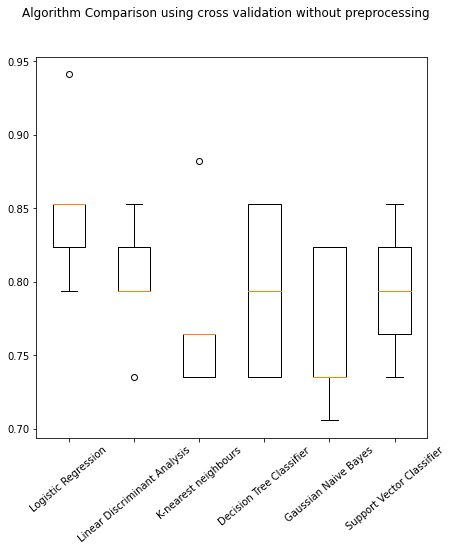

In [31]:
import matplotlib.pyplot as plt

# boxplot algorithm comparison
fig = plt.figure(figsize=(7,7))
fig.suptitle('Algorithm Comparison using cross validation without preprocessing')
ax = fig.add_subplot(111)
plt.boxplot(all_results_cv_test_wo_std)
ax.set_xticklabels(names, rotation=40)
plt.show()

##### With Standardization

In [33]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler


def standardize(x_train, x_test, type='zscore'):
    if type == 'zscore':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train_standardize = scaler.transform(x_train)
    # We apply the same transform on the test
    x_test_standardize = scaler.transform(x_test)
    return x_train_standardize, x_test_standardize


def cross_validation_with_standadization(X, y, model, num_folds=5):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy()

    cv = KFold(n_splits=num_folds, random_state=123, shuffle=True)
    results_train, results_test = [], []
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        
         # standardize with z-score
        X_train, X_test = standardize(x_train=X_train, x_test=X_test, type='zscore')
        
        clf = model.fit(X_train, y_train)
        accuracy_train = clf.score(X=X_train, y=y_train)
        accuracy_test = clf.score(X=X_test, y=y_test)  # Return the mean accuracy
        results_train.append(accuracy_train)
        results_test.append(accuracy_test)
    return results_train, results_test

In [34]:
all_results_cv_train_w_std, all_results_cv_test_w_std, names = [], [], []
for name, model in models:
    names.append(name)
    results_cv_train_w_std, results_cv_test_w_std = cross_validation_with_standadization(X=x_train, y=y_train, model=model, num_folds=5)
    all_results_cv_train_w_std.append(results_cv_train_w_std)
    all_results_cv_test_w_std.append(results_cv_test_w_std)
    means_train, stds_train = np.mean(results_cv_train_w_std), np.std(results_cv_train_w_std)
    means_test, stds_test = np.mean(results_cv_test_w_std), np.std(results_cv_test_w_std)
    msg = "%s: train = %.3f (+/- %.3f), test = %.3f (+/- %.3f)" % (name, means_train, stds_train, means_test, stds_test)
    print(msg)

Logistic Regression: train = 1.000 (+/- 0.000), test = 0.841 (+/- 0.078)
Linear Discriminant Analysis: train = 1.000 (+/- 0.000), test = 0.800 (+/- 0.039)
K-nearest neighbours: train = 0.901 (+/- 0.019), test = 0.841 (+/- 0.069)
Decision Tree Classifier: train = 1.000 (+/- 0.000), test = 0.794 (+/- 0.053)
Gaussian Naive Bayes: train = 0.876 (+/- 0.018), test = 0.847 (+/- 0.034)
Support Vector Classifier: train = 0.976 (+/- 0.006), test = 0.829 (+/- 0.060)


Let's plot the algorithm comparison ! 

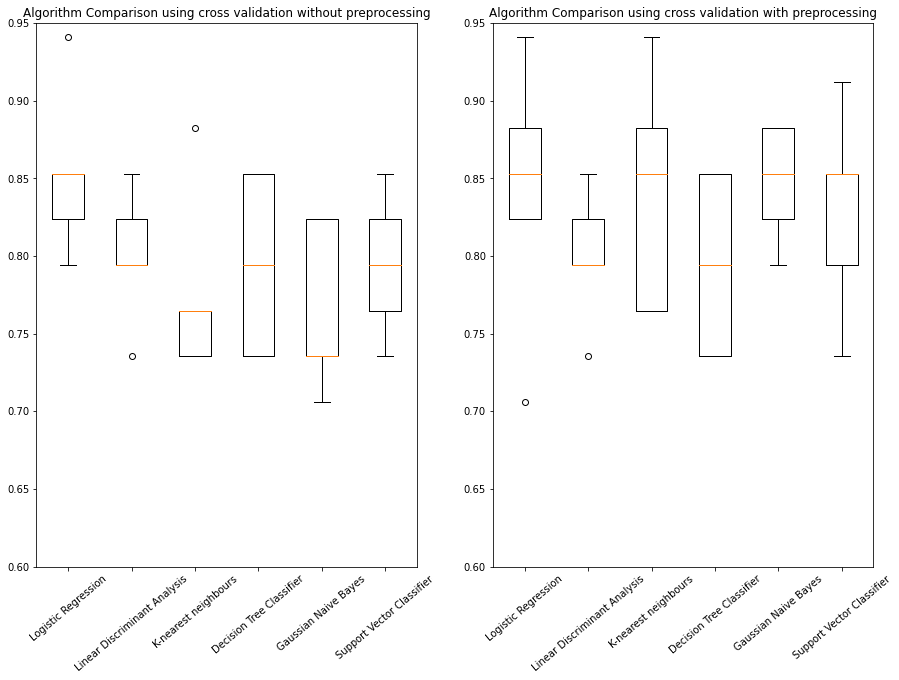

In [37]:
import matplotlib.pyplot as plt

# boxplot algorithm comparison
plt.figure(figsize=(15,10))

ax = plt.subplot(121)
plt.title('Algorithm Comparison using cross validation without preprocessing')
plt.boxplot(all_results_cv_test_wo_std)
ax.set_ylim([0.60, 0.95])
ax.set_xticklabels(names, rotation=40)

ax = plt.subplot(122)
plt.title('Algorithm Comparison using cross validation with preprocessing')
plt.boxplot(all_results_cv_test_w_std)
ax.set_ylim([0.60, 0.95])
ax.set_xticklabels(names, rotation=40)
plt.show();

# 3) Overfitting and Underfitting

- **Overfitting**:  
A model suffers from Overfitting when it has learned too much from the training data, and does not perform well in practice as a result. This is usually caused by the model having too much exposure to the training data. For the number classification example, if the model is overfit in this way, it may be picking up on tiny details that are misleading, like stray marks as an indication of a specific number

- **Underfitting**:  
A model suffers from Underfitting when it has not learned enough from the training data, and does not perform well in practice as a result. As a direct contrast to the previous idea, this issue is caused by not letting the model learn enough from training data. In the number classification example, if the training set is too small or the model has not had enough attempts to learn from it, then it will not be able to pick out key features of the numbers. (4)

<a href="https://arxiv.org/pdf/1811.12808.pdf">
  <img src="images/over_and_under_fitting.png" alt="over_under_fitting" class="center"  height="400" width="1000" >
</a>

*How to detect overfitting?*  
A key challenge with overfitting, and with machine learning in general, is that we **can’t know how well our model will perform on new data until we actually test it.** (5)

To address this, we can split our initial dataset into separate training and test subsets. This method can approximate of how well our model will perform on new data. If our model does much better on the training set than on the test set, then we’re likely overfitting.
For example, it would be a big red flag if our model saw 99% accuracy on the training set but only 55% accuracy on the test set.

*How to prevent overfitting?*  
- **Cross-validation**  
The idea is clever: Use your initial training data to generate multiple mini train-test splits. Use these splits to tune your model.
In standard k-fold cross-validation, we partition the data into k subsets, called folds. Then, we iteratively train the algorithm on k-1 folds while using the remaining fold as the test set (called the “holdout fold”). Cross-validation allows you to tune hyperparameters with only your original training set. This allows you to keep your test set as a truly unseen dataset for selecting your final model.
- **Train with more data**  
It won’t work every time, but training with more data can help algorithms detect the signal better. Of course, that’s not always the case. If we just add more noisy data, this technique won’t help. That’s why you should always ensure your data is clean and relevant.
- **Remove features**  
Some algorithms have built-in feature selection. For those that don’t, you can manually improve their generalizability by removing irrelevant input features.
- **Regularization**  
Regularization refers to a broad range of techniques for artificially forcing your model to be simpler. The method will depend on the type of learner you’re using. For example, you could prune a decision tree, use dropout on a neural network, or add a penalty parameter to the cost function in regression.
- **Also, Ensembling, early stopping ...**

# 4) Other hyperparameters optimization

Wikipedia states that "hyperparameter tuning/optimizization is choosing a set of optimal hyperparameters for a a learning algorithm". 
So what is a hyperparameter? [3]
<div align="center">
    <i> a hyperparameter is a parameter whose value is set before the learning process begins </i>
</div>

Some examples of hyperparameters include penalty in logistic regression 
In sklearn, hyperparameters are passed in as arguments of the constructor of the models classes.
   
**Tuning Strategies:**
 - Grid Search  
 Also known as an exhaustive search, Grid search looks through each combination of hyperparameters. This means that every combination of specified hyperparameter values will be tried.
 - Random Search  
 As its names suggests, Random Search uses random combinations of hyperparameters. This means that not all of the parameter values are tried, and instead, parameters will be sampled with fixed numbers of iterations.

<a href="http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf">
  <img src="images/random_grid_search.png" alt="random_grid_search class="center"  height="400" width="700" >
</a>

### Grid Search

We define a space for the Grid Search, we will work with z-score preprocessing in the pipeline

In [38]:
"""
Create a dictionary with classifier name as a key and it's hyper parameters options as a value for grid search
"""

import numpy as np

# Logistic Regression Params
C = [x for x in np.arange(0.1, 3, 0.2)]
penalty = ["l1", "l2"]
fit_intercept = [True, False]
solver = ["saga"]
lr_params = {'C': C,
             'penalty': penalty,
             'fit_intercept': fit_intercept,
             'solver': solver
             }

# DecisionTreeClassifier PARAMS
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
class_weight = [None, "balanced"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ["auto", "sqrt", "log2"]
dtc_params = {'criterion': criterion,
              'splitter': splitter,
              'class_weight': class_weight,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features
              }

# KNN PARAMS
n_neighbors = [int(x) for x in np.linspace(start=1, stop=20, num=2)]
weights = ["uniform", "distance"]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
leaf_size = [int(x) for x in np.linspace(start=5, stop=50, num=2)]
p = [int(x) for x in np.linspace(start=1, stop=4, num=1)]
knn_params = {'n_neighbors': n_neighbors,
              'weights': weights,
              'algorithm': algorithm,
              'leaf_size': leaf_size,
              'p': p,
              }

# LDA PARAMS
solver = ["lsqr"]
shrinkage = ["auto", None, 0.1, 0.3, 0.5, 0.7, 0.9]
lda_params = {'solver': solver,
              'shrinkage': shrinkage
              }

# GaussianNB PARAMS
var_smoothing = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
gnb_params = {'var_smoothing': var_smoothing,
              }

# SVC PARAMS
C = [x for x in np.arange(0.1, 2, 0.2)]
gamma = ["auto"]
kernel = ["linear", "poly", "rbf", "sigmoid"]
degree = [1, 2, 3, 4, 5, 6]
svc_params = {'C': C,
              'gamma': gamma,
              'kernel': kernel,
              'degree': degree,
              }

hypertuned_params_gs = {"Logistic Regression": lr_params,
                     "Decision Tree Classifier": dtc_params,
                     "K-nearest neighbours": knn_params,
                     "Linear Discriminant Analysis": lda_params,
                     "Gaussian Naive Bayes": gnb_params,
                     "Support Vector Classifier": svc_params,
                     }


**Exercice:** Complete the following script to:
- find the numbers of combination from hypertuned_params that Grid Search will evaluate for each models ("LR","DTC", "KNN" "LDA", "GNB", "SVC")

In [ ]:
#@title Exercise 6 {display-mode: "form"}
# %load solutions_exercices/find_combination.py


def find_combination_from_grid(grid):
    com = 1
    for x in grid.values():
        com *= len('''CompleteHere''')
    return '''CompleteHere'''


for key, value in hypertuned_params_gs.items():
    nb_combination = find_combination_from_grid(value)
    print("%s: %i combinations " % (key, nb_combination))


In [39]:
#@title Solution 6 {display-mode: "form"}
# %load solutions_exercices/find_combination.py


def find_combination_from_grid(grid):
    com = 1
    for x in grid.values():
        com *= len(x)
    return com


for key, value in hypertuned_params_gs.items():
    nb_combination = find_combination_from_grid(value)
    print("%s: %i combinations " % (key, nb_combination))
    

Logistic Regression: 60 combinations 
Decision Tree Classifier: 2592 combinations 
K-nearest neighbours: 32 combinations 
Linear Discriminant Analysis: 7 combinations 
Gaussian Naive Bayes: 5 combinations 
Support Vector Classifier: 240 combinations 


In [40]:
# grid search function
import numpy as np
import warnings
warnings.filterwarnings('ignore') 

def grid_search(X, y, name, model, param_grid, verbose=False):
    names = []
    names.append(name)
    result_gs, max_val_mean_test = [], 0 
    for i, params in enumerate(param_grid):
        model = model.set_params(**params)
        results_cv_train_w_std, results_cv_test_w_std = cross_validation_with_standadization(X=X, y=y, model=model, num_folds=5)
        mean_train, std_train = np.mean(results_cv_train_w_std), np.std(results_cv_train_w_std)
        mean_test, std_test = np.mean(results_cv_test_w_std), np.std(results_cv_test_w_std)
        if verbose:
            print("%s - iteration %i: %f (%f)" % (name, i, mean_test, std_test))
        if mean_test > max_val_mean_test:
            max_val_mean_test = mean_test
            max_val_std_test = std_test
            max_val_mean_train = mean_train
            max_val_std_train = std_train
            max_i = i
            best_params = param_grid[i] 
    msg = "%s: Maximum value on test = %.3f (+/- %.3f) with train = %.3f (+/- %.3f) for iteration %i with params: %s" % (name, max_val_mean_test, max_val_std_test, max_val_mean_train, max_val_std_train, max_i, best_params)
    print(msg)

In [41]:
from sklearn.model_selection import ParameterGrid

for name, model in models:
    param_grid = list(ParameterGrid(hypertuned_params_gs[name]))
    grid_search(X=x_train, y=y_train, name=name, model=model, param_grid=param_grid, verbose=False)  # you can set verbose to True to see each iteration

Logistic Regression: Maximum value on test = 0.876 (+/- 0.057) with train = 0.951 (+/- 0.014) for iteration 16 with params: {'C': 0.9000000000000001, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Linear Discriminant Analysis: Maximum value on test = 0.876 (+/- 0.060) with train = 0.901 (+/- 0.019) for iteration 6 with params: {'shrinkage': 0.9, 'solver': 'lsqr'}
K-nearest neighbours: Maximum value on test = 0.824 (+/- 0.105) with train = 0.851 (+/- 0.022) for iteration 2 with params: {'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
Decision Tree Classifier: Maximum value on test = 0.865 (+/- 0.024) with train = 0.944 (+/- 0.012) for iteration 10 with params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Gaussian Naive Bayes: Maximum value on test = 0.847 (+/- 0.034) with train = 0.876 (+/- 0.018) for iteration 0 with params: {'var_

You see that we have improve the performance with the grid search hyperparameters tunings.

### Random Search

We define a space for the Random Search, we will works with z-score preprocessing in the pipeline

In [42]:
"""
Create a dictionary with classifier name as a key and it's hyper parameters options as a value for Random search
"""

import numpy as np
from scipy.stats import uniform

# Logistic Regression Params
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)
penalty = ["l1", "l2"]
fit_intercept = [True, False]
solver = ["saga"]
lr_params = {'C': C,
             'penalty': penalty,
             'fit_intercept': fit_intercept,
             'solver': solver
             }

# DecisionTreeClassifier PARAMS
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
class_weight = [None, "balanced"]
max_depth = list(range(10, 501))
max_depth.append(None)
min_samples_split = list(range(2, 101))
min_samples_leaf = list(range(1, 50))
max_features = ["auto", "sqrt", "log2"]
dtc_params = {'criterion': criterion,
              'splitter': splitter,
              'class_weight': class_weight,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features
              }

# KNN PARAMS
n_neighbors = list(range(1, 101))
weights = ["uniform", "distance"]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
leaf_size = list(range(2, 101))
p = list(range(1, 11))
knn_params = {'n_neighbors': n_neighbors,
              'weights': weights,
              'algorithm': algorithm,
              'leaf_size': leaf_size,
              'p': p,
              }

# LDA PARAMS
solver = ["lsqr"]
shrinkage = ["auto", None, 0.1, 0.3, 0.5, 0.7, 0.9]
lda_params = {'solver': solver,
              'shrinkage': shrinkage
              }

# GaussianNB PARAMS
var_smoothing = uniform(loc=0, scale=0.1)
gnb_params = {'var_smoothing': var_smoothing,
              }

# SVC PARAMS
C =  uniform(loc=0, scale=2)
gamma = ["auto"]
kernel = ["linear", "poly", "rbf", "sigmoid"]
degree = list(range(1,11))
svc_params = {'C': C,
              'gamma': gamma,
              'kernel': kernel,
              'degree': degree,
              }

hypertuned_params_rs = {"Logistic Regression": lr_params,
                     "Decision Tree Classifier": dtc_params,
                     "K-nearest neighbours": knn_params,
                     "Linear Discriminant Analysis": lda_params,
                     "Gaussian Naive Bayes": gnb_params,
                     "Support Vector Classifier": svc_params,
                     }

In [43]:
# random search function
import random
import warnings
warnings.filterwarnings('ignore') 

def random_search(X, y, name, model, param_grid, nb_iterations, verbose=False):
    best_params = []
    names = []
    names.append(name)
    result_rs, max_val_mean_test = [], 0 
    for i in range(nb_iterations):
        # create random param from the grid dict
        params = {key: value.rvs() if isinstance(value, type(uniform())) else random.choice(value) for key, value in param_grid.items()}
        model = model.set_params(**params)
        results_cv_train_w_std, results_cv_test_w_std = cross_validation_with_standadization(X=X, y=y, model=model, num_folds=5)
        mean_train, std_train = np.mean(results_cv_train_w_std), np.std(results_cv_train_w_std)
        mean_test, std_test = np.mean(results_cv_test_w_std), np.std(results_cv_test_w_std)
        if verbose:
            print("%s - iteration %i: %f (%f)" % (name, i, mean_test, std_test))
        if mean_test > max_val_mean_test:
            max_val_mean_test = mean_test
            max_val_std_test = std_test
            max_val_mean_train = mean_train
            max_val_std_train = std_train
            max_i = i
            best_params = params
    msg = "%s: Maximum value on test = %.3f (+/- %.3f) with train = %.3f (+/- %.3f) for iteration %i with params: %s" % (name, max_val_mean_test, max_val_std_test, max_val_mean_train, max_val_std_train, max_i, best_params)
    print(msg)

In [44]:
for name, model in models:
    dic_grid = hypertuned_params_rs[name]
    random_search(X=x_train, y=y_train, name=name, model=model, param_grid=dic_grid, nb_iterations=100, verbose=False)  # you can set verbose to True to see each iteration

Logistic Regression: Maximum value on test = 0.876 (+/- 0.057) with train = 0.951 (+/- 0.014) for iteration 3 with params: {'C': 0.8683354519823312, 'penalty': 'l1', 'fit_intercept': True, 'solver': 'saga'}
Linear Discriminant Analysis: Maximum value on test = 0.876 (+/- 0.060) with train = 0.901 (+/- 0.019) for iteration 0 with params: {'solver': 'lsqr', 'shrinkage': 0.9}
K-nearest neighbours: Maximum value on test = 0.847 (+/- 0.022) with train = 0.869 (+/- 0.016) for iteration 20 with params: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 27, 'p': 5}
Decision Tree Classifier: Maximum value on test = 0.876 (+/- 0.047) with train = 0.876 (+/- 0.012) for iteration 9 with params: {'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced', 'max_depth': 426, 'min_samples_split': 22, 'min_samples_leaf': 41, 'max_features': 'auto'}
Gaussian Naive Bayes: Maximum value on test = 0.847 (+/- 0.034) with train = 0.876 (+/- 0.017) for iteration 1 with para

Here, we have implemented our own Grid Search and Random Search function to understand the mechanism. Sklearn directly implements the functions, [Random Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) and [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

# 5) Ensembling

No free lunch theorem states that no machine learning algorithm is universally better than the others in all domains. The goal of ensembling is to combine multiple learner to improve the applicability and get better performance. But always remember, if two models have comparable performance, then you should usually pick the simpler one. [Occam's razor](https://simple.wikipedia.org/wiki/Occam%27s_razor)

### Voting

Voting is arguably the most straightforward way to combine multiple learners $d^{(j)}(\cdot)$. The idea is to take a linear combination of the predictions made by the learners. For example, in multiclass classification, we have
$$\tilde{y}_k =\sum_j^L w_j d^{(j)}_k(\boldsymbol{x}), \text{ where }w_j\geq 0\text{ and }\sum_j w_j=1,$$<p>for any class $k$, where $L$ is the number of voters. This can be simplified to the <strong>plurarity vote</strong> where each voter has the same weight:</p>
$$\tilde{y}_k =\sum_j \frac{1}{L} d^{(j)}_k(\boldsymbol{x}).$$<p>Let's use the <code>VotingClassifier</code> from Scikit-learn to combine <code>KNeighborsClassifer</code> ,<code>DecisionTreeClassifier</code> and <code>SVC</code>  together and train on our datasets</p>

We will use the Sklearn <code>Pipeline</code> tools which allow to combine all the steps we've seen previously


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(**{'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}, random_state=random_state)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(**{'class_weight': None, 'criterion': 'gini', 'max_depth': 80, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}, random_state=random_state)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(**{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 20, 'p': 1, 'weights': 'distance'})]])
pipe4 = Pipeline([['sc', StandardScaler()], ['clf', LinearDiscriminantAnalysis(**{'shrinkage': 0.7, 'solver': 'lsqr'})]])
pipe5 = Pipeline([['sc', StandardScaler()], ['clf', GaussianNB(**{'var_smoothing': 1e-09})]])
pipe6 = Pipeline([['sc', StandardScaler()], ['clf', SVC(**{'C': 0.5000000000000001, 'degree': 1, 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True}, random_state=random_state)]])

We can estimate the performance of individual classifiers via the 5-fold CV:

In [ ]:
from sklearn.model_selection import cross_validate

clf_labels = ['LR', 'DTC', 'KNN', 'LDA', 'GNB', 'SVC']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3, pipe4, pipe5, pipe6], clf_labels):
    results = cross_validate(estimator=pipe, X=x_train, y=y_train, cv=5, scoring='accuracy', return_train_score=True)
    scores_test = results['test_score']
    scores_train = results['train_score']
    print('%s: train = %.3f (+/- %.3f), test = %.3f (+/- %.3f)' % (label, scores_train.mean(), scores_train.std(), scores_test.mean(), scores_test.std()))

Let's combined the classifiers by <code>VotingClassifer</code> from Scikit-learn and experiment some weight combinations:

In [ ]:
from sklearn.ensemble import VotingClassifier
import itertools

print('[Voting]')
best_vt, best_w, best_test_score, best_train_score = None, (), -1, 1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('dtc', pipe2), ('knn', pipe3), ('svc', pipe6)], 
                           voting='soft', weights=[a,b,c])
    results = cross_validate(estimator=clf, X=x_train, y=y_train, cv=5, scoring='accuracy', return_train_score=True)
    scores_test = results['test_score']
    scores_train = results['train_score']
    print('%s: train = %.3f (+/- %.3f), test = %.3f (+/- %.3f)' % ((a,b,c), scores_train.mean(), scores_train.std(), scores_test.mean(), scores_test.std()))
    if best_test_score < scores_test.mean() and best_train_score > scores_train.mean():
        best_vt, best_w, best_test_score = clf, (a, b, c), scores_test.mean()

print('\nBest %s: %.3f' % (best_w, best_test_score))

The best ensemble combines the <code>DecisionTreeClassifier</code> and <code>SVC</code>. This is a reasonable choice because these two models "complement" each other in design.

# 6) Final prediction and Evaluation metrics

This is the moment you've been waiting for! We will finally be able to evaluate our test set. Our final model will be an ensemble and combines the <code>DecisionTreeClassifier</code> and <code>SVC</code> with a z-score features preprocessing. A decision tree does not need a z-score preprocessing because by nature the algorithm is scale invariant. Let's fit the model on all the training data.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, confusion_matrix, auc

pipe2 = Pipeline([['clf', DecisionTreeClassifier(**{'class_weight': None, 'criterion': 'gini', 'max_depth': 80, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}, random_state=0)]])
pipe6 = Pipeline([['sc', StandardScaler()], ['clf', SVC(**{'C': 0.5000000000000001, 'degree': 1, 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True})]])

clf = VotingClassifier(estimators=[('dtc', pipe2), ('svc', pipe6)], voting='soft', weights=[1,2])
clf.fit(x_train, y_train)
classes = clf.classes_

# Here we have the probabilty associate to each classes
proba_test = clf.predict_proba(x_test)[:,1] # [:,1] referes to the second class HGG
y_pred = np.where(proba_test>0.5, 1, 0) # Here we have the prediction


# 1 -- Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2 -- ROC curve 
fp_rates, tp_rates, _ = roc_curve(y_test, proba_test, pos_label=1)
roc_auc = auc(fp_rates, tp_rates)

tn, fp, fn, tp = [i for i in cm.ravel()]

# 3 -- Calculate each metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F1 = 2 * (precision * recall) / (precision + recall)
accuracy = (tn + tp) / (tn + fp + fn + tp)

printout = (
        f'Precision: {round(precision, 3)} | '
        f'Recall: {round(recall, 3)} | '
        f'F1 Score: {round(F1, 3)} | '
        f'Accuracy Score: {round(accuracy, 3)} | '
        f'ROC auc: {round(roc_auc, 3)} | '

    )
print(printout)

Now let's go plot the confusion matrix ! 

In [ ]:
import matplotlib.pyplot as plt


# 1 -- Confusion matrix
# https://stackoverflow.com/questions/48817300/sklearn-plot-confusion-matrix-combined-across-trainingtest-sets
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(10,5))
plot_confusion_matrix(cm, classes=['HGG', 'LGG'],
                      title='Confusion matrix')

# display of predicted value is not center in the middle of confusion matrix. This is actually a bug of the last version of matplotlib

Now lets plot the roc curve !

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.title('ROC Curve', size=15)
plt.legend(loc="lower right")
plt.subplots_adjust(wspace=.3)
plt.tight_layout()
plt.show()

Distribution of predicted probabilty for each class 

In [ ]:
df = pd.DataFrame({'probPos': proba_test, 'target': y_test})
plt.figure(figsize=(10,5))
plt.hist(df[df.target == 0].probPos, density=True, bins=25,
             alpha=.5, color='green', label='LGG')
plt.hist(df[df.target == 1].probPos, density=True, bins=25,
             alpha=.5, color='red', label='HGG')
plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
plt.xlim([0, 1])
plt.title('Distributions of Predictions', size=15)
plt.xlabel('Positive Probability (predicted)', size=13)
plt.ylabel('Samples (normalized scale)', size=13)
plt.legend(loc="upper right")
plt.show();